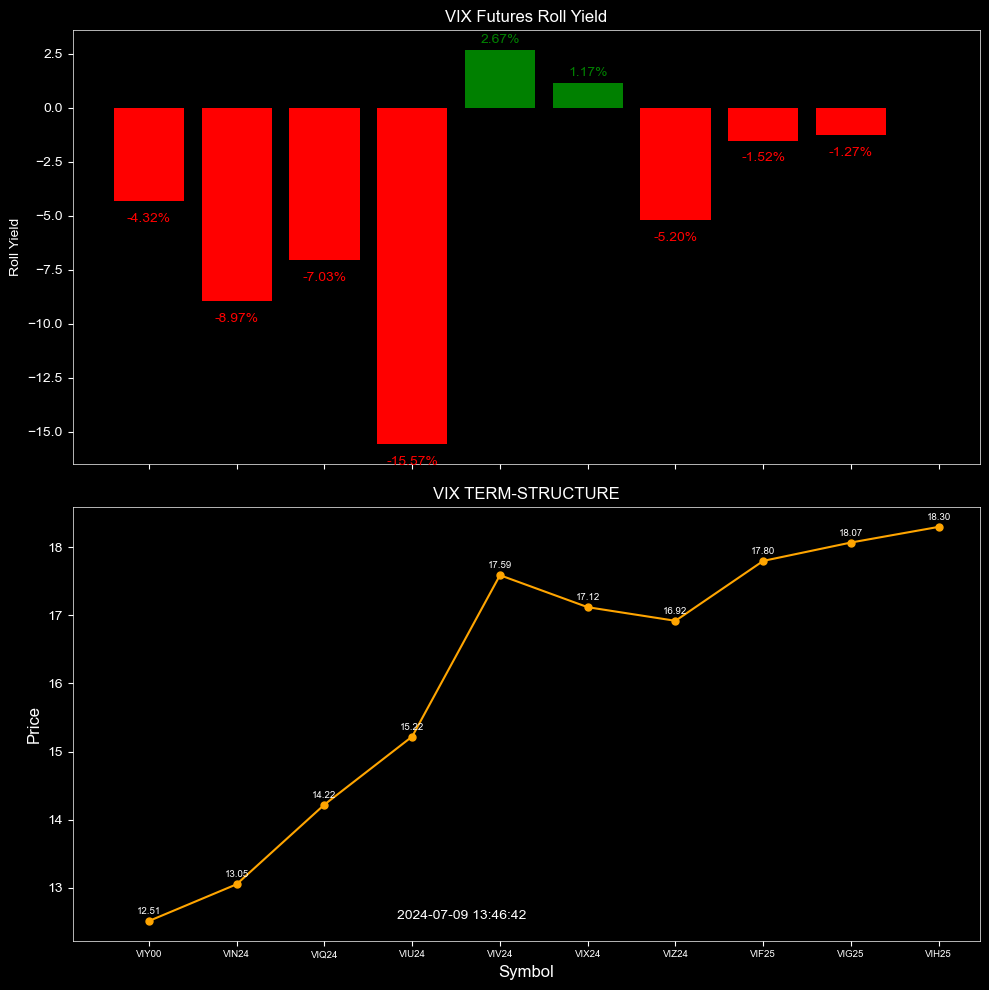

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import requests
from urllib.parse import unquote

# Configuration for better display in console
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)

# Headers for the API request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0",
}

# Function to fetch live data from the API
def fetch_live_data(url):
    with requests.Session() as req:
        req.headers.update(headers)
        r = req.get(url[:25])
        req.headers.update({'X-XSRF-TOKEN': unquote(r.cookies.get_dict()['XSRF-TOKEN'])})
        params = {
            "list": "futures.contractInRoot",
            'root': 'VI',
            "fields": "symbol,symbolName,lastPrice,priceChange,percentChange,lastUpdate",
            "orderBy": "expiration",
            "orderDir": "desc",
            "between(lastPrice,.10,)": "",
            "between(tradeTime,2024-01-01,2024-12-30)": "",
            "meta": "field.shortName,field.type,field.description",
            "hasOptions": "true",
            "page": "1",
            "limit": "500",
            "raw": "1"
        }
        r = req.get(url, params=params).json()
        df = pd.DataFrame(r['data'])
        return df

# Calculate roll yield
def calculate_roll_yield(current_price, next_price):
    return (float(current_price) - float(next_price)) / float(current_price) * 100

# Main function to process data and generate plots
def main():
    url = 'https://www.barchart.com/proxies/core-api/v1/quotes/get?'
    df = fetch_live_data(url)
    
    roll_yields = []
    contango_backwardation = []
    long_short = []
    
    for i in range(len(df) - 1):
        current_price = df.iloc[i]['lastPrice']
        next_price = df.iloc[i + 1]['lastPrice']
        
        current_price = float(current_price[:-1]) if isinstance(current_price, str) and current_price.endswith('s') else float(current_price)
        next_price = float(next_price[:-1]) if isinstance(next_price, str) and next_price.endswith('s') else float(next_price)
        
        roll_yield = calculate_roll_yield(current_price, next_price)
        roll_yields.append(roll_yield)
        
        if roll_yield > 0:
            contango_backwardation.append("Contango")
            long_short.append("Long (Green)")
        elif roll_yield < 0:
            contango_backwardation.append("Backwardation")
            long_short.append("Short (Red)")
        else:
            contango_backwardation.append("No Change")
            long_short.append("No Trade")

    # Plotting
    colors = ['green' if ry > 0 else 'red' for ry in roll_yields]

    plt.style.use('dark_background')
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'white'
    plt.rcParams['axes.linewidth'] = 0.5

    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    axs[0].bar(range(len(roll_yields)), roll_yields, color=colors)

    for i, (ry, color) in enumerate(zip(roll_yields, colors)):
        axs[0].annotate(f"{ry:.2f}%", (i, ry), textcoords="offset points", xytext=(0, 5 if ry > 0 else -15), ha='center', fontsize=10, color=color)

    axs[0].set_ylabel("Roll Yield")
    axs[0].set_title("VIX Futures Roll Yield")

    axs[0].set_xticks(range(len(contango_backwardation) - 1))
    axs[0].set_xticklabels(contango_backwardation[:-1], rotation=45)

    symbols = []
    prices = []
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    for _, row in df.iterrows():
        symbols.append(row['symbol'])
        prices.append(float(row['lastPrice'].replace("s", "")))

    x = np.arange(len(prices))

    axs[1].plot(x, prices, color='orange', marker='o', markersize=5)
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(symbols, fontsize=7)

    for i, j in zip(x, prices):
        axs[1].annotate(f"{j:.2f}", (i, j), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=7)

    axs[1].set_xlabel("Symbol", fontsize=12)
    axs[1].set_ylabel("Price", fontsize=12)
    axs[1].set_title("VIX TERM-STRUCTURE")

    axs[1].text(0.5, 0.05, timestamp, ha='right', fontsize=10, transform=axs[1].transAxes)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()